# Data modelling

## Summary:

At this stage, the goal is to fit different predictive models (increasing in complexity) to try to predict NPP from all the bioclimatic variables and the latitude data. This is therefore a **regression** exercise.  
The idea is to use the metrics to compare the performance of each model between them, as well as with the results obtained using the Miami Model.  
The evaluation metrics will be:
- PMAE (percentage mean absolute error)
- RMSE (root mean squared error)

PMAE will be considered as the main metric, but RMSE will also be taken into consideration.

### Load libraries
`raster` for spatial data manipulation (and also parallelization options)  
`caret` as the main library for machine learning models  
`tidyverse` for data manipulation  
`randomForest` for Random Forest algorithms  

In [1]:
library(raster)
library(caret)
library(tidyverse)
library(randomForest)


Warning message:
"package 'raster' was built under R version 3.5.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 3.5.3"
Warning message:
"package 'caret' was built under R version 3.5.3"
Loading required package: lattice

Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 3.5.3"
Warning message:
"package 'tidyverse' was built under R version 3.5.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
v purrr   0.3.3     

Warning message:
"package 'tibble' was built under R version 3.5.3"
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Warning message:
"package 'readr' was built under R version 3.5.3"
Warning message:
"package 'purrr' was built under R version 3.5.3"
Warning message:
"package 'dplyr' was built under R version 3.5.3"
Warning messa

### Load data

Load the config with the main paths of the project and common parameters

In [2]:
source("D:/TFM Data Science/config.R")


Load the dataset

In [3]:
points_df  <- read.csv(file.path(path_project, "35k_data.csv"), header = T)
head(points_df)

x,y,NPP,Miami_NPP,bio_1,bio_10,bio_11,bio_12,bio_13,bio_14,...,bio_18,bio_19,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,...,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
46.95833,33.95833,67.57400,823.1034,13.771042,25.048666,2.87500,483,95,1,...,4,216,14.734917,37.48008,904.1935,35.660,-3.654,39.314,3.674167,24.691500
-68.37500,62.62500,26.51500,249.1695,-9.130459,6.202167,-24.35150,426,66,19,...,171,63,6.868083,16.24774,1251.1346,12.443,-29.828,42.271,5.645167,-20.405167
76.62500,56.29167,335.03201,652.9854,0.299625,16.454500,-16.57317,423,62,14,...,176,65,10.541417,22.56490,1347.4503,24.651,-22.065,46.716,16.454500,-8.005834
142.20833,-19.45833,165.92000,1030.7825,26.169043,30.409166,20.47783,634,175,3,...,324,16,14.481916,55.17971,409.5968,37.810,11.565,26.245,30.185333,22.099001
110.04167,44.12500,67.82632,207.6032,5.249708,22.711500,-13.89867,108,32,1,...,74,5,13.160583,24.98687,1480.3439,30.300,-22.370,52.670,22.711500,-13.898666
-64.95833,-25.29167,1264.48096,1092.5557,18.808666,23.416166,13.19567,682,148,3,...,399,13,11.883000,49.57033,420.2774,29.430,5.458,23.972,22.615000,13.195666


Create a dataframe for the models excluding the unused variables (latitude and Miami Model results), the NAs and values of NPP of 5 or below (to avoid near 0 or false NAs).

In [11]:
df_modelo <- points_df %>% dplyr::select(-x, -Miami_NPP) %>% filter(NPP > 5)
df_modelo$y <- abs(df_modelo$y)
df_modelo <- na.omit(df_modelo)
cat("Number of final observations")
nrow(df_modelo)
cat("Number of variables (included target)")
ncol(df_modelo)

Number of final observations

[1] 34634

Number of variables (included target)

[1] 21

Create a sample for train-test.  
The split will be 80% train, 20% test

In [16]:
set.seed(seed)
sample <- sample.int(n = nrow(df_modelo), size = floor(.80*nrow(df_modelo)), replace = F)

In [17]:
df_train <- na.omit(df_modelo[sample, ])
df_test  <- na.omit(df_modelo[-sample, ])

In [18]:
cat("Number of train observations")
nrow(df_train)
cat("Number of test observations")
nrow(df_test)

Number of train observations

[1] 27707

Number of test observations

[1] 6927

Additionally, create a version of the dataset that includes transformation of the variables:
- min-max transformation for the predictive variables (bioclims and y)
- log transformation for the target (NPP)

In [19]:
normalize_minmax <- function(x)
{
  return((x- min(x)) /(max(x)-min(x)))
}

In [20]:
df_modelo_norm <- df_modelo
for(i in 1:ncol(df_modelo_norm)){
  if(names(df_modelo_norm)[i] != "NPP"){
    df_modelo_norm[,i] <- normalize_minmax(df_modelo_norm[,i])
  } else{
    df_modelo_norm[,i] <- log(df_modelo_norm[,i])
  }
}

In [21]:
df_train_norm <- na.omit(df_modelo_norm[sample, ])
df_test_norm  <- na.omit(df_modelo_norm[-sample, ])

### Miami Model results

Check the results obtained from the Miami Model as if it was an externally trained model (so everything is test)

Load the data

In [22]:
NPP_eval <- points_df %>% select(NPP, Miami_NPP) %>% filter(NPP > 5 & Miami_NPP > 5) %>% na.omit() 



Calculate PMAE and RMSE

In [23]:
results_miami <- data.frame("Model"="Miami model",
                             "PMAE Train"=NA,
                             "PMAE Test"=mean(abs(NPP_eval$NPP - NPP_eval$Miami_NPP)/NPP_eval$NPP),
                             "RMSE Train"=NA,
                             "RMSE Test"=sqrt(mean((NPP_eval$NPP - NPP_eval$Miami_NPP)^2)))
results_miami

Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<lgl>,<dbl>,<lgl>,<dbl>
Miami model,NA,2.503517,NA,752.4965


### Naive model

A model based on the median value of NPP as naive predictor

In [24]:
results_median <- data.frame("Model"="Naive (median)",
                          "PMAE Train"=mean(abs(df_train$NPP - median(df_train$NPP))/df_train$NPP),
                          "PMAE Test"=mean(abs(df_test$NPP - median(df_test$NPP))/df_test$NPP),
                          "RMSE Train"=sqrt(mean((df_train$NPP - median(df_train$NPP))^2)),
                          "RMSE Test"=sqrt(mean((df_test$NPP - median(df_test$NPP))^2)))

results_median


Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Naive (median),1.964358,1.964724,368.8422,369.6854


### Linear model (1 variable)

Linear model based on only the variable with the highest linear regression coefficient (bio_12)

In [25]:
reg_lm <- lm(NPP~bio_12, data=df_train)
reg_lm



Call:
lm(formula = NPP ~ bio_12, data = df_train)

Coefficients:
(Intercept)       bio_12  
   156.9056       0.3487  


In [26]:
results_lm <- data.frame("Model"="LM (1 var)",
                          "PMAE Train"=mean(abs(df_train$NPP - predict(reg_lm, df_train))/df_train$NPP),
                          "PMAE Test"=mean(abs(df_test$NPP - predict(reg_lm, df_test))/df_test$NPP),
                         "RMSE Train"=sqrt(mean((df_train$NPP - predict(reg_lm, df_train))^2)),
                         "RMSE Test"=sqrt(mean((df_test$NPP - predict(reg_lm, df_test))^2)))
results_lm

Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
LM (1 var),1.196982,1.199671,248.2068,244.8694


### Multivariate linear model  
Linear model using all variables as predictors

In [27]:
reg_lm_mv <- lm(NPP~., data=df_train)
reg_lm_mv


Call:
lm(formula = NPP ~ ., data = df_train)

Coefficients:
(Intercept)            y        bio_1       bio_10       bio_11       bio_12  
   107.3771       4.2565      98.8147     -48.8998     -82.2022       0.2388  
     bio_13       bio_14       bio_15       bio_16       bio_17       bio_18  
    -0.6924      -3.2735      -2.0746       0.1588       0.4404       0.5106  
     bio_19        bio_2        bio_3        bio_4        bio_5        bio_6  
    -0.1293     -13.1613       7.9893      -0.4471      14.9561      19.3633  
      bio_7        bio_8        bio_9  
         NA      -1.7642      -2.1374  


In [28]:
results_lm_mv <- data.frame("Model"="Multivar LM",
                         "PMAE Train"=mean(abs(df_train$NPP - predict(reg_lm_mv, df_train))/df_train$NPP),
                         "PMAE Test"=mean(abs(df_test$NPP - predict(reg_lm_mv, df_test))/df_test$NPP),
                         "RMSE Train"=sqrt(mean((df_train$NPP - predict(reg_lm_mv, df_train))^2)),
                         "RMSE Test"=sqrt(mean((df_test$NPP - predict(reg_lm_mv, df_test))^2)))
results_lm_mv

Warning message in predict.lm(reg_lm_mv, df_train):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(reg_lm_mv, df_test):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(reg_lm_mv, df_train):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(reg_lm_mv, df_test):
"prediction from a rank-deficient fit may be misleading"


Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Multivar LM,0.8421816,0.8738457,211.9685,211.5147


### Multivariate linear model with transformation
Like the previous one, but using the transformed dataset

In [29]:
reg_lm_mv_t <- lm(NPP~., data=df_train_norm)
reg_lm_mv_t


Call:
lm(formula = NPP ~ ., data = df_train_norm)

Coefficients:
(Intercept)            y        bio_1       bio_10       bio_11       bio_12  
    13.5326       1.2211      19.6264      -6.3201     -32.1239       3.0214  
     bio_13       bio_14       bio_15       bio_16       bio_17       bio_18  
    -1.8682      -0.8895      -2.2044       3.9456      -2.8338       4.0362  
     bio_19        bio_2        bio_3        bio_4        bio_5        bio_6  
    -0.5621      -0.7455       1.6001     -11.4786       6.3312       5.7200  
      bio_7        bio_8        bio_9  
         NA       0.5500      -1.3450  


To be comparable, the prediction needs to reverse the logarithmic transformation (using 'exp')

In [30]:
results_lm_mv_t <- data.frame("Model"="Multivar LM (trans)",
                            "PMAE Train"=mean(abs(df_train$NPP - exp(predict(reg_lm_mv_t, df_train_norm)))/df_train$NPP),
                            "PMAE Test"=mean(abs(df_test$NPP - exp(predict(reg_lm_mv_t, df_test_norm)))/df_test$NPP),
                            "RMSE Train"=sqrt(mean((df_train$NPP - exp(predict(reg_lm_mv_t, df_train_norm)))^2)),
                            "RMSE Test"=sqrt(mean((df_test$NPP - exp(predict(reg_lm_mv_t, df_test_norm)))^2)))

results_lm_mv_t

Warning message in predict.lm(reg_lm_mv_t, df_train_norm):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(reg_lm_mv_t, df_test_norm):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(reg_lm_mv_t, df_train_norm):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(reg_lm_mv_t, df_test_norm):
"prediction from a rank-deficient fit may be misleading"


Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Multivar LM (trans),0.7439702,0.7645439,2095.676,674.0376


**It's improving!!**  
Ok, this is fun, let's go up a notch

### K-nearest neighbours
KNN model with tunning to find the best parameter for the number of neighbours, using 5-fold cross-validation.

In [31]:
reg_KNN <- caret::train(NPP~.,
                 data = df_train,
                 method = "knn",
                 trControl = trainControl(method = "repeatedcv", number = 5, repeats=10), # Seleccionar metodo de resampling (#aqui: repeated 10-fold CV)
                 tuneGrid = expand.grid(k = seq(2,10))) # Generar la malla de valores de parámetros para buscar optimo

k-Nearest Neighbors 

27707 samples
   20 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 22166, 22164, 22165, 22167, 22166, 22165, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
   2  153.9080  0.8214930  86.62361
   3  150.6680  0.8272301  86.74555
   4  150.6136  0.8266694  87.91382
   5  151.2053  0.8250142  89.17854
   6  152.0437  0.8229045  90.43932
   7  152.9462  0.8206954  91.55682
   8  153.9293  0.8183143  92.67658
   9  154.8825  0.8160268  93.72972
  10  155.7417  0.8139500  94.68217

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 4.

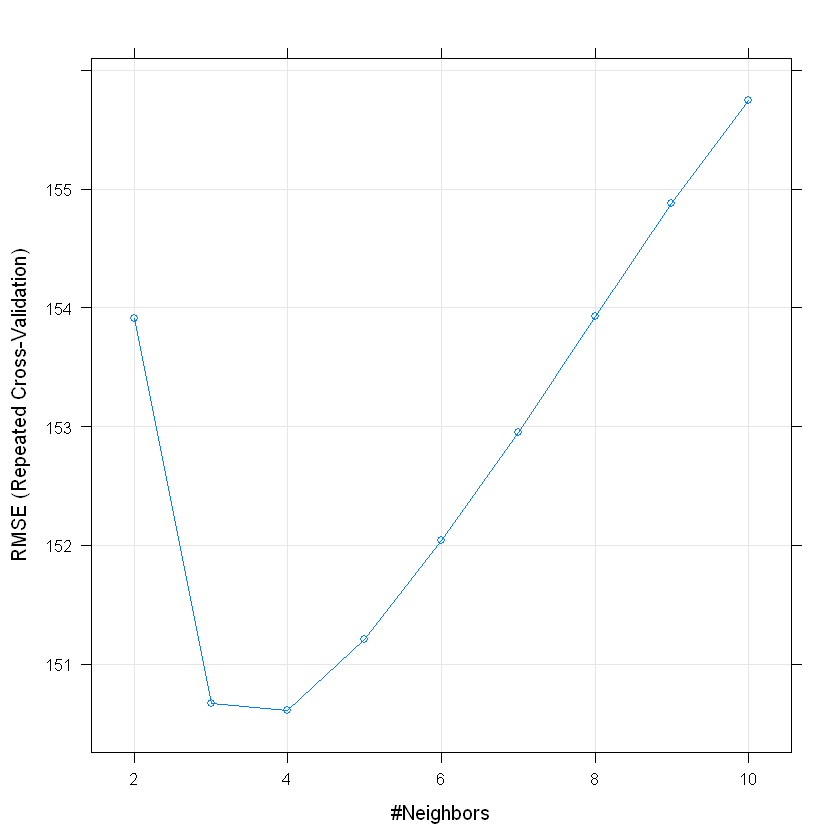

In [32]:
reg_KNN
plot(reg_KNN)

In [33]:
results_KNN <- data.frame("Model"="KNN",
                          "PMAE Train"=mean(abs(df_train$NPP - predict(reg_KNN, df_train))/df_train$NPP),
                          "PMAE Test"=mean(abs(df_test$NPP - predict(reg_KNN, df_test))/df_test$NPP),
                          "RMSE Train"=sqrt(mean((df_train$NPP - predict(reg_KNN, df_train))^2)),
                          "RMSE Test"=sqrt(mean((df_test$NPP - predict(reg_KNN, df_test))^2)))
results_KNN

Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
KNN,0.2476266,0.3497608,109.164,142.9929


### K-nearest neighbours w/ transformation
Same process as before, but using the transformed dataset to keep all predictive variables in the same scale, and smooth the extreme differences between high and low values of NPP.

In [34]:
beginCluster()
reg_KNN_norm <- train(NPP~.,
                 data = df_train_norm,
                 method = "knn",
                 trControl = trainControl(method = "repeatedcv", number = 5, repeats=10), # Seleccionar metodo de resampling (#aqui: repeated 10-fold CV)
                 tuneGrid = expand.grid(k = seq(2,10))) # Generar la malla de valores de parámetros para buscar optimo
endCluster()

Loading required namespace: parallel

12 cores detected, using 11



k-Nearest Neighbors 

27707 samples
   20 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 22165, 22166, 22165, 22166, 22166, 22166, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   2  0.2763936  0.9281942  0.1648669
   3  0.2722279  0.9301579  0.1646915
   4  0.2734142  0.9295077  0.1670049
   5  0.2752857  0.9285535  0.1693448
   6  0.2777120  0.9273229  0.1718892
   7  0.2804862  0.9259053  0.1745591
   8  0.2831943  0.9245090  0.1769541
   9  0.2859873  0.9230522  0.1793066
  10  0.2886505  0.9216627  0.1815714

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 3.

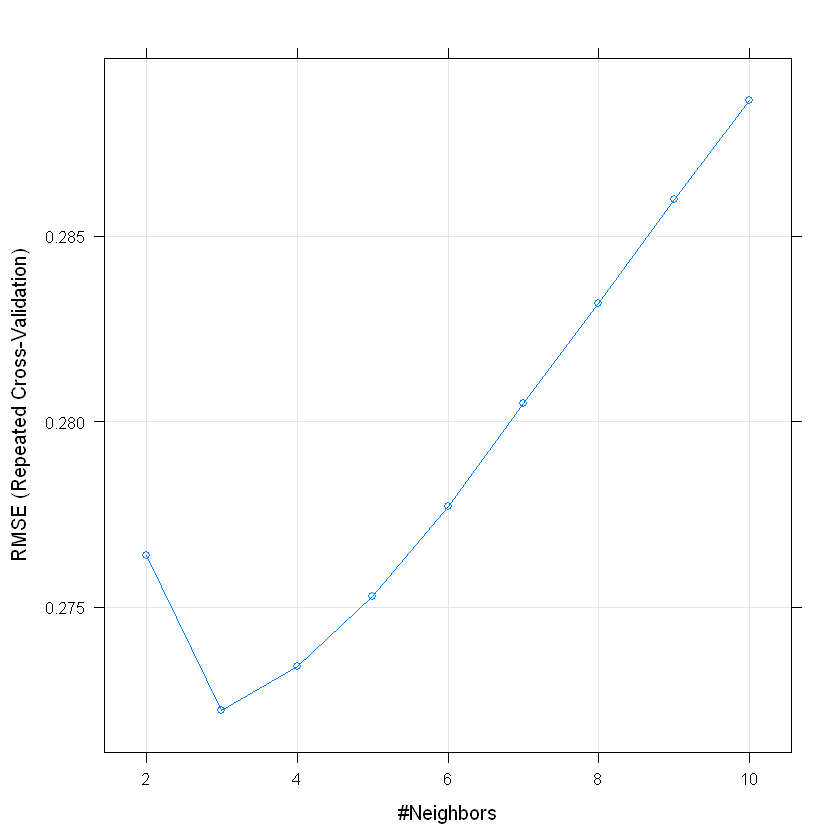

In [35]:
reg_KNN_norm
plot(reg_KNN_norm)

To be comparable, the prediction needs to reverse the logarithmic transformation (using 'exp')

In [37]:
pred_log_train <- exp(predict(reg_KNN_norm, df_train_norm))
pred_log_test <- exp(predict(reg_KNN_norm, df_test_norm))

In [38]:
results_KNN_trans <- data.frame("Model"="KNN transformed",
                          "PMAE Train"=mean(abs(df_train$NPP - pred_log_train)/df_train$NPP),
                          "PMAE Test"=mean(abs(df_test$NPP - pred_log_test)/df_test$NPP),
                          "RMSE Train"=sqrt(mean((df_train$NPP - pred_log_train)^2)),
                          "RMSE Test"=sqrt(mean((df_test$NPP - pred_log_test)^2)))
results_KNN_trans

Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
KNN transformed,0.1110015,0.1764586,69.5238,100.5477


In [ ]:
#Save the model as RDS file
saveRDS(reg_KNN_norm, file.path(path_models, "KNN_norm_train_35k.rds"))

### Decision Tree regression
Regression tree using cross validation to find the best tune for the complexity parameter (influences the overall size of the tree)

In [39]:
reg_tree <- train(NPP~., data = df_train,
                  method = "rpart",
                  trControl = trainControl("cv", number = 20),
                  tuneLength = 50)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


CART 

27707 samples
   20 predictor

No pre-processing
Resampling: Cross-Validated (20 fold) 
Summary of sample sizes: 26323, 26321, 26319, 26321, 26322, 26322, ... 
Resampling results across tuning parameters:

  cp            RMSE      Rsquared   MAE     
  0.0008701973  159.6264  0.8046855  108.9782
  0.0008797742  159.7770  0.8043364  109.1336
  0.0008919412  159.9291  0.8039610  109.2934
  0.0009013783  159.9895  0.8038044  109.3682
  0.0009123753  160.2794  0.8030924  109.6282
  0.0009144390  160.3795  0.8028512  109.7030
  0.0009165385  160.4646  0.8026379  109.7883
  0.0009265886  160.5869  0.8023405  109.9156
  0.0009696587  161.4655  0.8001144  110.8031
  0.0010086241  161.9471  0.7989315  111.2372
  0.0010302302  162.3311  0.7980048  111.5639
  0.0010933112  163.1123  0.7960467  112.2253
  0.0011532614  163.9532  0.7939642  113.0377
  0.0012513280  164.7413  0.7919536  113.7801
  0.0012568753  164.7715  0.7918735  113.7795
  0.0012685646  164.9893  0.7913344  113.9973
  0.0

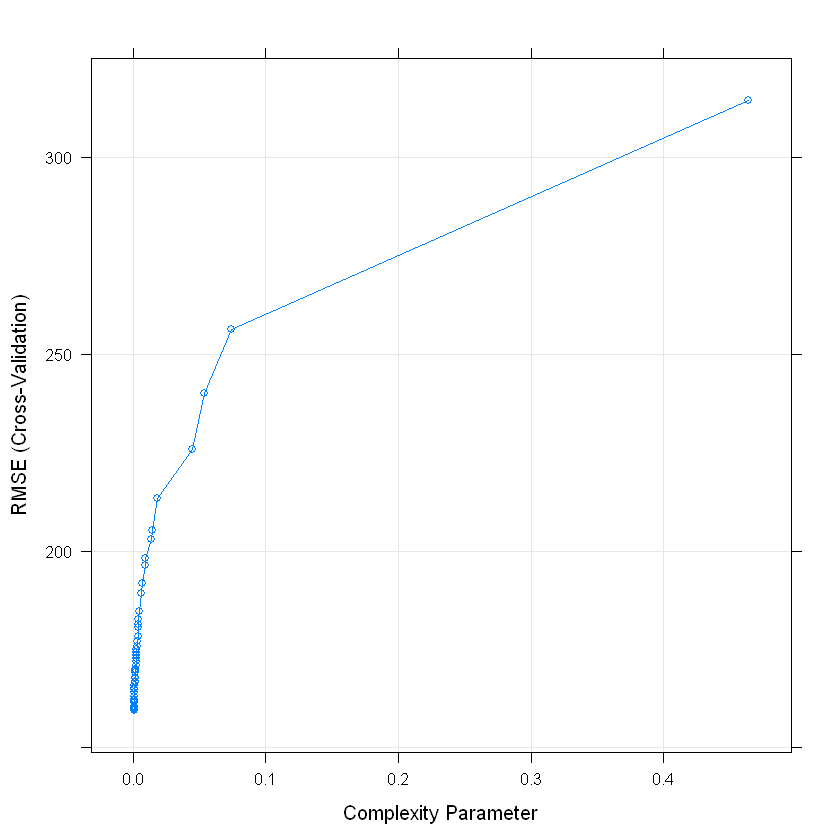

In [40]:
reg_tree
plot(reg_tree)

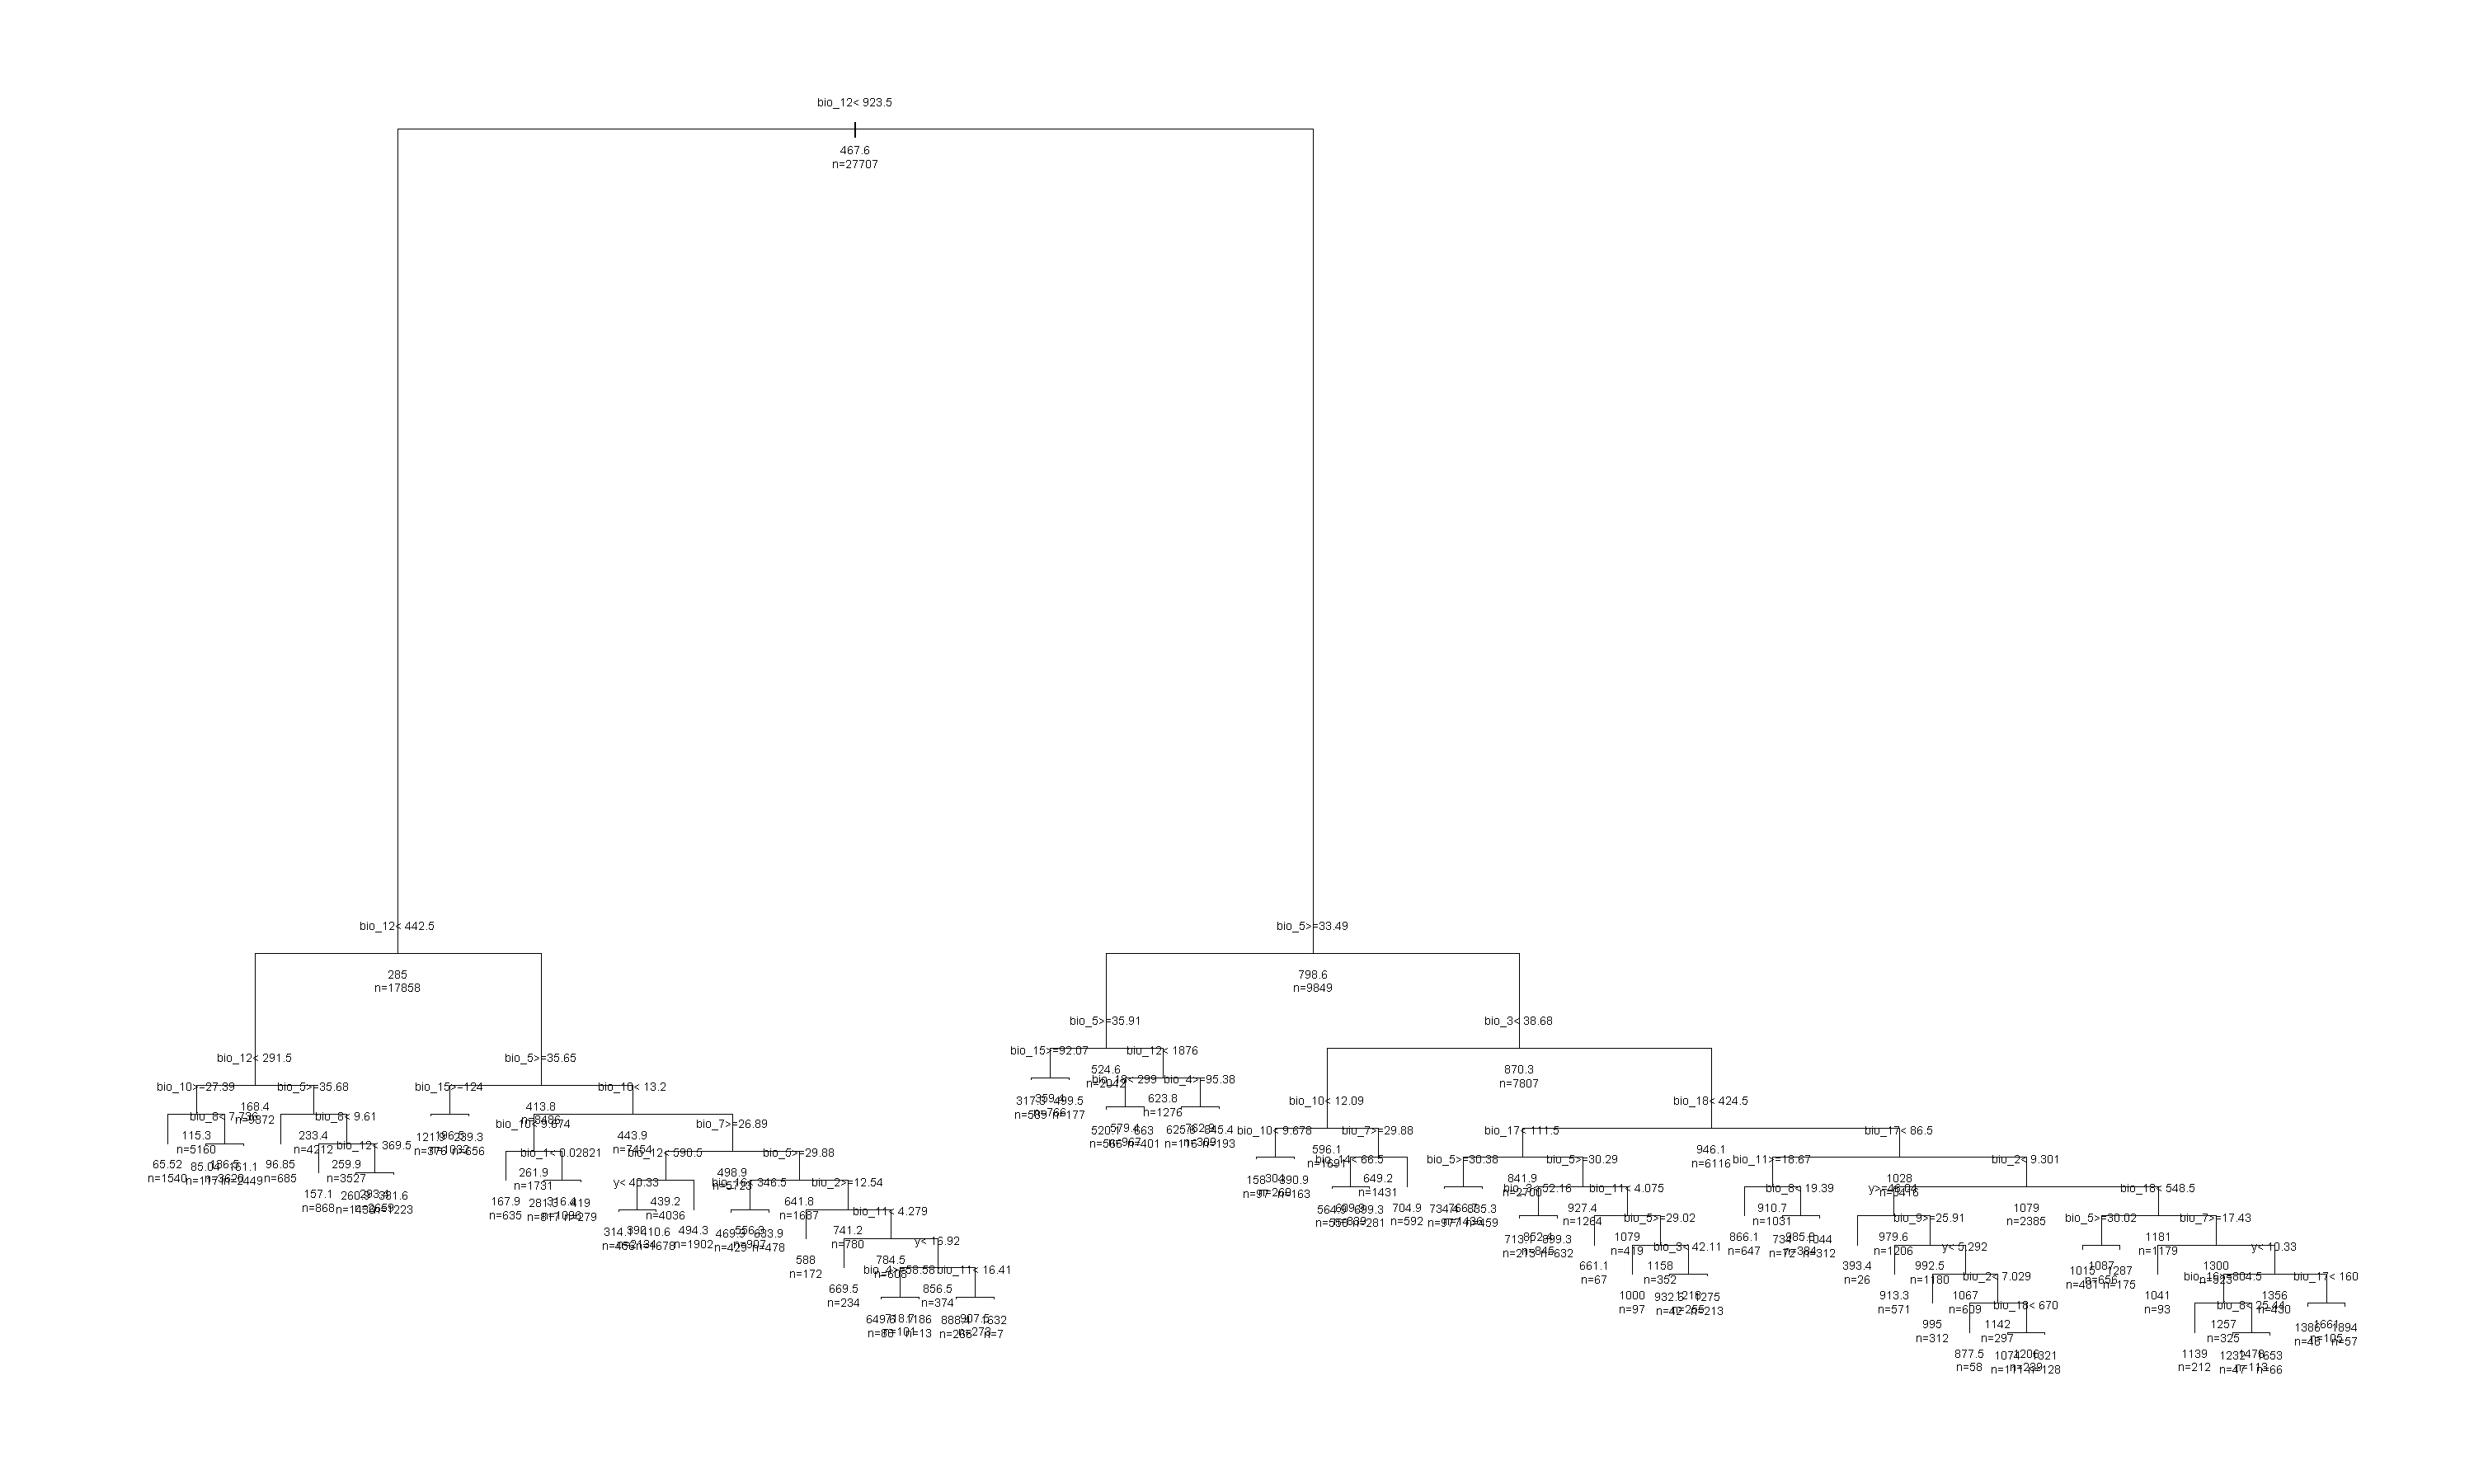

In [45]:
options(repr.plot.width = 25, repr.plot.height = 15)
plot(reg_tree$finalModel)
text(reg_tree$finalModel, use.n=TRUE, all=TRUE, cex=.7)

I know, the visualization is not great

In [42]:
results_tree_car <- data.frame("Model"="Regression Tree",
                          "PMAE Train"=mean(abs(df_train$NPP - predict(reg_tree, df_train))/df_train$NPP),
                          "PMAE Test"=mean(abs(df_test$NPP - predict(reg_tree, df_test))/df_test$NPP),
                          "RMSE Train"=sqrt(mean((df_train$NPP - predict(reg_tree, df_train))^2)),
                          "RMSE Test"=sqrt(mean((df_test$NPP - predict(reg_tree, df_test))^2)))
results_tree_car

Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Regression Tree,0.492976,0.5328042,151.7777,162.1575


In [ ]:
#Save model as RDS file
saveRDS(reg_tree, file.path(path_models, "TREE_train_35k.rds"))

### Random Forest
Random forest regression, with previous search for the best _mtry_ parameter that determines the ammount of variables to be randomly sampled in each split

In [ ]:
set.seed(seed)
bestmtry <- tuneRF(df_train[,!names(df_train)=="NPP"], df_train$NPP, stepFactor=1.5, improve=1e-5, ntree=500)
print(bestmtry)

Spoiler: the result is 7

In [46]:
beginCluster()
reg_rf_tune <- randomForest(NPP~., data=df_train, mtry=7)
reg_rf_tune
endCluster()

12 cores detected, using 11




Call:
 randomForest(formula = NPP ~ ., data = df_train, mtry = 7) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 7

          Mean of squared residuals: 9720.151
                    % Var explained: 92.54

In [47]:
results_tree_rf_tune <- data.frame("Model"="RandomForest with tunning",
                              "PMAE Train"=mean(abs(df_train$NPP - predict(reg_rf_tune, df_train))/df_train$NPP),
                              "PMAE Test"=mean(abs(df_test$NPP - predict(reg_rf_tune, df_test))/df_test$NPP),
                              "RMSE Train"=sqrt(mean((df_train$NPP - predict(reg_rf_tune, df_train))^2)),
                              "RMSE Test"=sqrt(mean((df_test$NPP - predict(reg_rf_tune, df_test))^2)))

results_tree_rf_tune

Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
RandomForest with tunning,0.08289495,0.2080613,40.94156,99.35309


In [ ]:
#Save the model as RDS file
saveRDS(reg_rf_tune, file.path(path_models, "RF_train_tune_35k.rds"))

## Compare metrics

Time to combine the metrics from all of the models and evaluate them altogether.

In [48]:
all_results <- rbind(results_miami,
                     results_median,
                     results_lm,
                     results_lm_mv,
                     results_lm_mv_t,
                     results_KNN,
                     results_KNN_trans,
                     results_tree_car,
                     results_tree_rf_tune)
all_results

Model,PMAE.Train,PMAE.Test,RMSE.Train,RMSE.Test
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Miami model,NA,2.5035168,NA,752.49647
Naive (median),1.96435790,1.9647244,368.84219,369.68542
LM (1 var),1.19698171,1.1996709,248.20682,244.86940
Multivar LM,0.84218158,0.8738457,211.96854,211.51472
Multivar LM (trans),0.74397024,0.7645439,2095.67569,674.03760
KNN,0.24762662,0.3497608,109.16401,142.99285
KNN transformed,0.11100154,0.1764586,69.52380,100.54772
Regression Tree,0.49297604,0.5328042,151.77770,162.15745
RandomForest with tunning,0.08289495,0.2080613,40.94156,99.35309


In [49]:
#Save the results as csv
write.csv(all_results, file.path(path_models, "Summary_all_models_metrics_35k.csv"))

There is a progressive improvement on the metrics of the models, reaching promising values.  
  
However, all models have one thing in common: **overfitting**.  
In most of the models, the values of the metrics in test increase compared to the results from train, which is probably indicating an overfitting of the models to the train data. This is likely because there is so much variation in NPP values due to natural causes (not necessarily climate-driven), that every model triest to fit it as best as it can to the train data, but the test data always introduces new noise.  
In previous iterations of this project (results not shown), studying a smaller area (the Iberian Peninsula and surroundings), the sampling captured most of the surface and not only did the models returned even better metrics, but also the overfitting (as difference between train and test metrics) decreased. 

  
Nevertheless, the results from the **KNN (transformed)** and **Random Forest** models are the most accurate to the real data, and will be used to compare predictions on map data.